In [24]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time # delay within program
from math import *
import random
import pickle
import os
import json
import copy

import nidaqmx # laser output
from pyueye import ueye
from pypyueye import Camera

from improc import *
from simple_worm_env import *

# Init checks

In [32]:
templates,bodies = load_templates()
cam,task = init_instruments()

In [52]:
bgs = make_vec_bg(cam,task,[0,1],total_time=20)

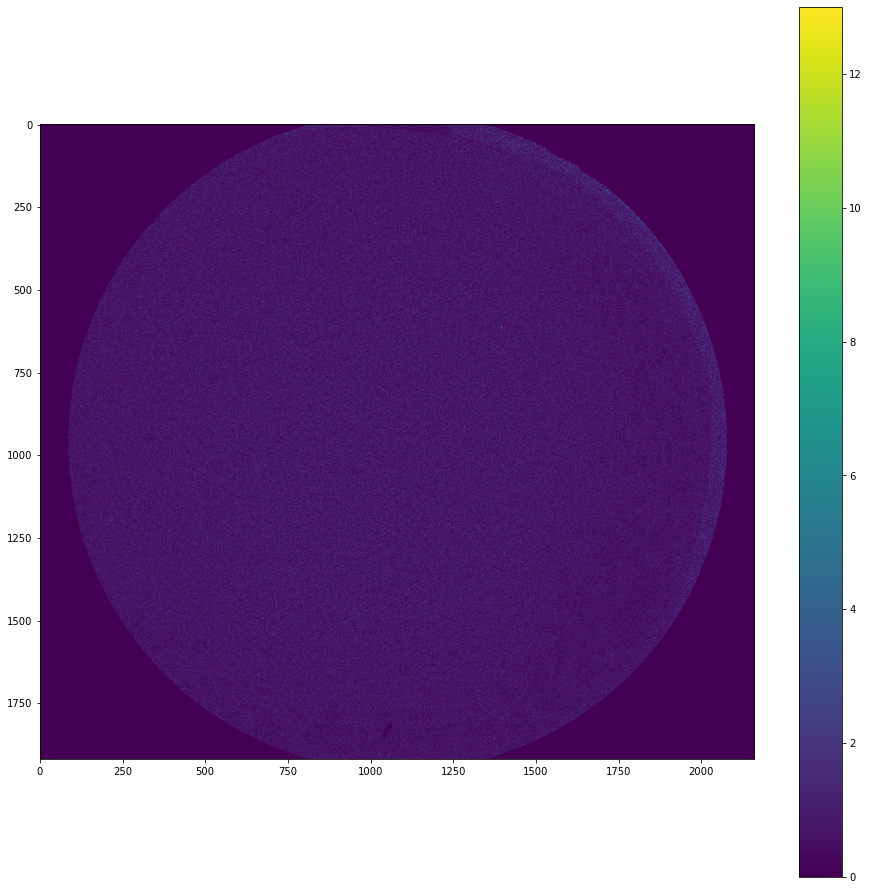

In [53]:
# Check that things are working
plt.figure(figsize=(16,16))
img = grab_im(cam,bgs[0])
plt.imshow(img)
plt.colorbar();

[{'loc': array([1201.17283951, 1065.9382716 ]), 'img': array([[0, 0, 0, ..., 2, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [3, 1, 0, ..., 3, 2, 1],
       ...,
       [0, 1, 0, ..., 3, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       [1, 2, 2, ..., 0, 2, 0]], dtype=uint8), 'scores': array([130452,  65767]), 'angs': array([180,   0]), 'endpts': array([[1192, 1209],
       [1064, 1070]]), 'body': 120}]


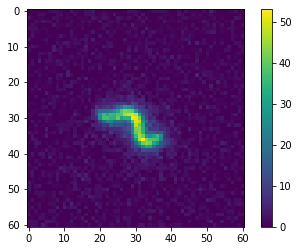

In [6]:
worms = find_worms(img,templates,bodies)
print(worms)
plt.imshow(worms[0]['img'])
plt.colorbar();

In [7]:
track,angs,lights = if_stmt_angle(180,cam,task,bgs,templates,bodies,total_time=30)

Finding orientation
elapsed 2

1
	 1178.83 -1061.21
	body 120 head 240 light 1
2
	 1173.94 -1060.9
	body 210 head 180 light 1
3
	 1169.68 -1062.73
	body 210 head 210 light 0
5
	 1166.84 -1063.99
	body 210 head 120 light 1
6
	 1162.21 -1064.35
	body 150 head 180 light 1
7
	 1158.04 -1063.3
	body 150 head 90 light 0
8
	 1153.65 -1061.5
	body 150 head 240 light 1
10
	 1147.72 -1060.65
	body 210 head 150 light 1
11
	 1142.94 -1061.1
	body 210 head 210 light 0
12
	 1138.76 -1061.46
	body 210 head 120 light 1
14
	 1133.24 -1060.82
	body 150 head 180 light 1
15
	 1128.37 -1059.03
	body 150 head 180 light 1
16
	 1124.32 -1058.26
	body 150 head 210 light 1
18
	 1119.19 -1057.42
	body 210 head 180 light 1
19
	 1114.08 -1057.83
	body 210 head 180 light 1
20
	 1109.34 -1057.8
	body 210 head 150 light 1
22
	 1104.33 -1058.34
	body 150 head 210 light 1
23
	 1099.54 -1058.54
	body 210 head 150 light 1
24
	 1095.33 -1058.41
	body 150 head 210 light 1
25
	 1090.23 -1058.31
	body 150 head 120 light 0
27

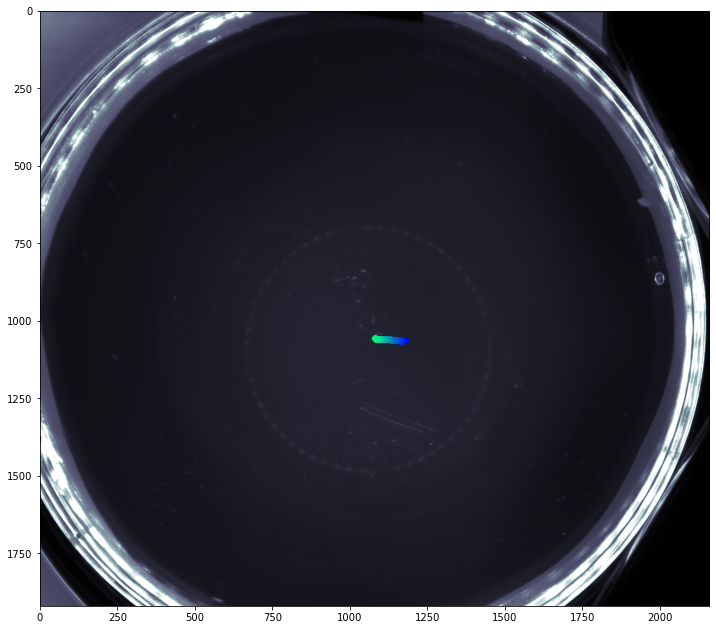

In [8]:
fig,ax = plt.subplots(1)
img = grab_im(cam,None)
ax.imshow(img,cmap='bone')
fig.set_size_inches((12,12))
NPOINTS = track.shape[0]
ax.set_prop_cycle('color',plt.cm.winter(np.linspace(0,1,NPOINTS)))
for i in range(NPOINTS-1):
    ax.scatter(track[i,1],track[i,2])
    ax.set_aspect('equal','box')
plt.savefig('ClosedLoop0.png')

In [56]:
traj = np.load('Data/Known_easy_i0_1.npz',allow_pickle=True)

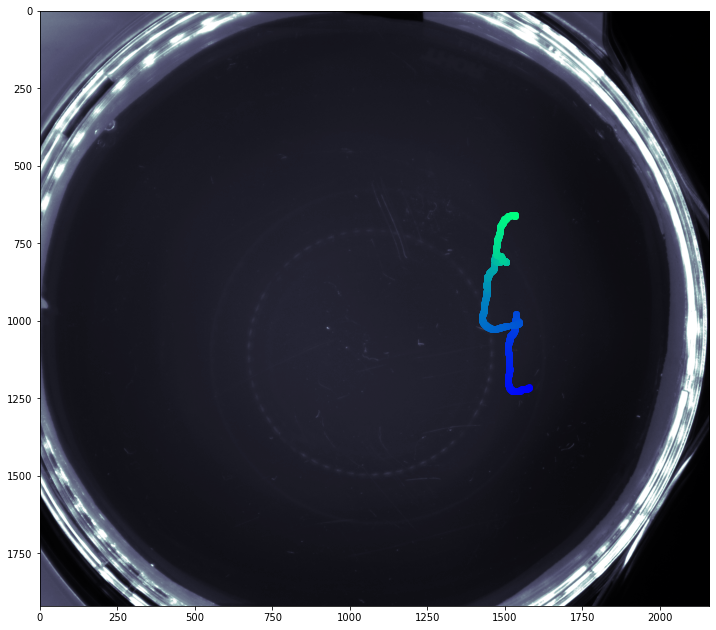

In [57]:
fig,ax = plt.subplots(1)
img = grab_im(cam,None)
ax.imshow(img,cmap='bone')
fig.set_size_inches((12,12))
NPOINTS = traj['loc'].shape[0]
ax.set_prop_cycle('color',plt.cm.winter(np.linspace(0,1,NPOINTS)))
for i in range(NPOINTS-1):
    ax.scatter(traj['loc'][i,0],traj['loc'][i,1])
    ax.set_aspect('equal','box')
plt.savefig('Known1.png')

In [9]:
cam.exit()
task.write(0)
task.close()

# Deterministic policy

In [4]:
def det_policy(obs):
    # Returns 0 if obs is nans.
    # Otherwise, returns the known deterministic policy.
    if np.isnan(obs):
        return 0
    if obs < 0:
        action = 1
    elif obs == 0:
        action = 0
    else:
        action = 0
    return action

In [6]:
env.close()

In [7]:
fbase = 'Data/Known_easy_i0_'
env = ProcessedWorm(0,ep_len=300)
eps_per_worm = 2

curr_ep = 0
WORM_NUMBER = 0


for i_episode in np.arange(eps_per_worm-curr_ep)+curr_ep+WORM_NUMBER*eps_per_worm:
    done = False
    fname = fbase+str(i_episode)+'.npz'
    trajectory = {}
    action = 0
    
    obs = env.reset(target=(i_episode*90)%360)
    
    while not done:
        obs, r, done, info = env.step(action)
        print('{}:\t {}\t r:{}\t\t\r'.format(int(info['t']),
                                             obs,round(r,2)),end='')
        
        # Combining trajectory data in info with previous steps
        add_to_traj(trajectory,info)
        
        # Chooses action for next step
        action = det_policy(obs)
        
    print("Episode finished after {} timesteps".format(int(trajectory['t'][-2])))
    np.savez(fname, **trajectory)
    
env.close()

C:\Users\ccli3\miniconda3\envs\r911\lib\site-packages\nidaqmx\task.py:102: ResourceWarning: Task of name "_unnamedTask<0>" was not explicitly closed before it was destructed. Resources on the task device may still be reserved.
  warnings.warn(


C:\Users\ccli3\Documents\Research\20_09_07_NewPC\Worms4TF\09_16_RLEnv\improc.py:205: RuntimeWarning: invalid value encountered in longlong_scalars
  centers.append(np.array([np.sum(np.arange(im_sz)*sumx) / np.sum(sumx), np.sum(np.arange(im_sz)*sumy) / np.sum(sumy)]))


Episode finished after 299 timesteps


C:\Users\ccli3\miniconda3\envs\r911\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Episode finished after 299 timesteps


# Q tables with TD learning

In [10]:
class QTab_Agent():
    """
    General Q table agent.
    This one is for the simple environment.
    """
    def __init__(self,SA_discrete=(3,2),alpha=0.01,gamma=0.9,eps=0.05):
        # SA_discrete is (state,action) sizes
        # alpha is learning step size
        # gamma is discount factor
        # eps is the proportion of time random actions are selected
        
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        
        self.qtab = np.random.normal(scale=0.1,size=SA_discrete)
        self.obs_count = np.zeros(SA_discrete)
        
    def load(self,fname):
        chkpt = np.load(fname,allow_pickle=True)
        self.alpha = chkpt['alpha']
        self.gamma = chkpt['gamma']
        self.eps = chkpt['eps']
        
        self.qtab = chkpt['qtab']
        self.obs_count = chkpt['count']
        
    def learn(self, obs, obs_next, act, reward):
        # Takes obs_t, act_t, r_{t+1} and updates table if all values are valid.
        # DEG_STEP is the angle increment for discretizing states
        
        # Q table update step:
        # Q_t+1 (s,a) <- Q_t(s,a) + alpha([r+gamma*max_a'(Q_t(s',a'))] - Q_t(s,a))
        
        if np.isnan(obs) or np.isnan(obs_next):
            return
        
        i_obs = self.obs2ind(obs)
        i_obs_next = self.obs2ind(obs_next)
        
        # Update rule and update count
        self.qtab[i_obs,act] = self.qtab[i_obs,act] + \
            self.alpha*(reward+self.gamma*np.max(self.qtab[i_obs_next,:])
                  - self.qtab[i_obs,act])
        self.obs_count[i_obs,act] += 1
        
    def sample(self, obs):
        # Finds the best action for a given state.
        # eps of the time, returns a random choice for exploration.
        if np.isnan(obs):
            return 0
        if np.random.uniform() < self.eps:
            return np.random.randint(0,2)
        i_obs = self.obs2ind(obs) 
        return np.argmax(self.qtab[i_obs,:])
    
    def eval_sample(self, obs):
        # Runs an evaluation sampling (no epsilon.)
        # Finds best action for given obs.
        if np.isnan(obs):
            return 0
        i_obs = self.obs2ind(obs)
        return np.argmax(self.qtab[i_obs,:])
        
    def obs2ind(self,obs):
        # Maps -1, 0, 1 to 0,1,2.
        return int(obs+1)
    
    def save(self,fname):
        # Saves agent as npz file with keys 'qtab' and 'count'.
        agent_dict = {
            'qtab':self.qtab,
            'count':self.obs_count,
            'eps':self.eps,
            'alpha':self.alpha,
            'gamma':self.gamma
        }
        np.savez(fname,**agent_dict)

In [12]:
env.close()

In [29]:
fbase = 'Data/Qtab_easy_i3_'
env = ProcessedWorm(0,ep_len=100)
eps_per_worm = 8

curr_ep = 0
WORM_NUMBER = 0

agent = QTab_Agent()
#agent.load('Data/Qtab_i0_61_agent.npz')

for i_episode in np.arange(eps_per_worm-curr_ep)+curr_ep+WORM_NUMBER*eps_per_worm:
    done = False
    fname = fbase+str(i_episode)+'.npz'
    trajectory = {}
    action = 0
    
    old_obs = env.reset(target=(i_episode*90)%360)
    
    while not done:
        obs, r, done, info = env.step(action)
        print('{}:\t {}\t r:{}\t\t\r'.format(int(info['t']),
                                             np.around(info['loc'],1),round(r,2)),end='')
        
        # Combining trajectory data in info with previous steps
        info['qtab'] = copy.deepcopy(agent.qtab)
        info['agent_count'] = copy.deepcopy(agent.obs_count)
        add_to_traj(trajectory,info)
        
        # Trains agent and chooses action for next step
        agent.learn(old_obs,obs,action,r)
        action = agent.sample(obs)
        old_obs = obs
        
    print("Episode finished after {} timesteps".format(int(trajectory['t'][-2])))
    np.savez(fname, **trajectory)
    agent.save(fname[:-4]+'_agent.npz')
            
env.close()

Episode finished after 99 timesteps
Episode finished after 99 timesteps
Episode finished after 99 timesteps
Episode finished after 99 timesteps
Episode finished after 99 timesteps
Episode finished after 100 timesteps
Episode finished after 100 timesteps
Episode finished after 99 timesteps


In [28]:
env.close()